In [85]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# 1. Charger le dataset
dataset, info = tfds.load('malaria', as_supervised=True, with_info=True, shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Utilisateur\tensorflow_datasets\malaria\incomplete.JELINY_1.0.0\malaria-train.tfrecord*...:…

Dataset malaria downloaded and prepared to C:\Users\Utilisateur\tensorflow_datasets\malaria\1.0.0. Subsequent calls will reuse this data.


In [86]:
# Informations sur le dataset
print("Description du dataset :")
print(info.description)
print("\nNombre total d'exemples :", info.splits['train'].num_examples)

Description du dataset :
The Malaria dataset contains a total of 27,558 cell images with equal instances
of parasitized and uninfected cells from the thin blood smear slide images of
segmented cells.

Nombre total d'exemples : 27558


In [87]:
# 2. Définir les fractions pour division en entraînement, validation et test
train_split = 0.8
val_split = 0.1
test_split = 0.1

# Diviser les données en sous-ensembles
train_data = dataset['train'].take(int(info.splits['train'].num_examples * train_split))
val_data = dataset['train'].skip(int(info.splits['train'].num_examples * train_split)).take(int(info.splits['train'].num_examples * val_split))
test_data = dataset['train'].skip(int(info.splits['train'].num_examples * (train_split + val_split)))

# Vérification des tailles des datasets
print(f"Exemples d'entraînement : {len(list(train_data))}")
print(f"Exemples de validation : {len(list(val_data))}")
print(f"Exemples de test : {len(list(test_data))}")

Exemples d'entraînement : 22046
Exemples de validation : 2755
Exemples de test : 2756


In [88]:
# 3. Prétraitement des données
batch_size = 32
img_size = (128, 128)  # Taille des images cible

def preprocess_image(image, label):
    """
    Prétraite une image :
    - Redimensionne l'image
    - Normalise les pixels entre 0 et 1
    """
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def encode_label(label):
    """
    Encode les labels en format binaire :
    - 1 pour 'Parasitized'
    - 0 pour 'Uninfected'
    """
    return tf.cast(label, tf.float32)  # Assure un format compatible avec les modèles TensorFlow

# Appliquer le prétraitement et l'encodage binaire des labels
def preprocess_and_encode(image, label):
    image = preprocess_image(image, label)
    label = encode_label(label)
    return image, label

train_data = train_data.map(preprocess_and_encode, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(preprocess_and_encode, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_and_encode, num_parallel_calls=tf.data.AUTOTUNE)

# Ajouter batching et préchargement pour optimiser l'entraînement
train_data = train_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


Visualisation des données d'entraînement :


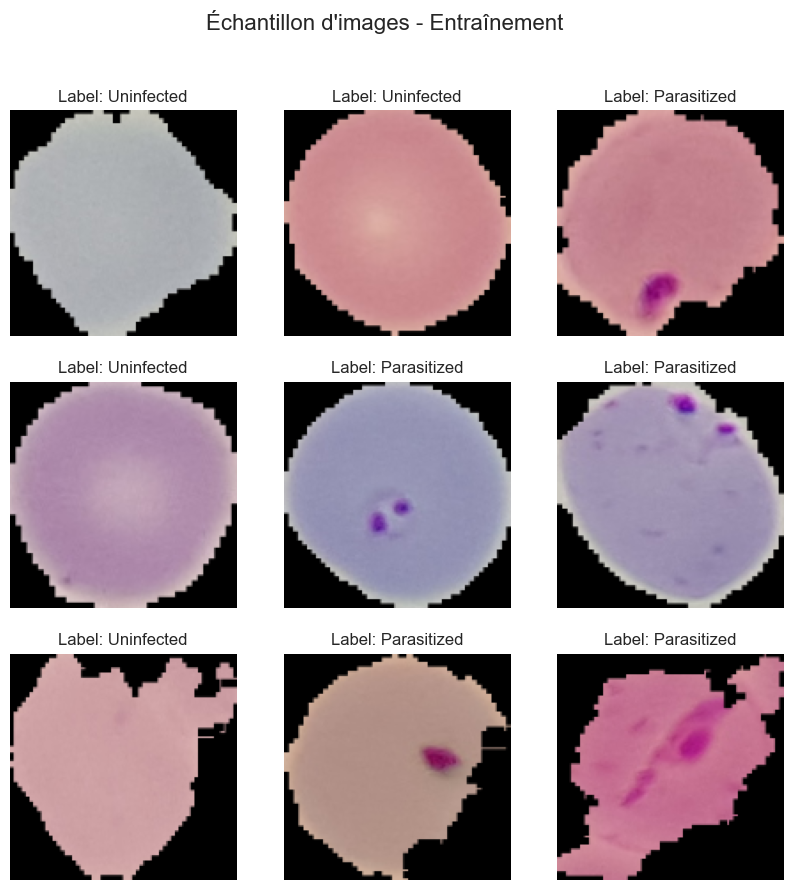

In [89]:
# 4. Visualiser un échantillon d'images et leurs labels
def visualize_sample(dataset, title, class_names=['Parasitized', 'Uninfected']):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Prenez un batch pour visualisation
        for i in range(9):  # Affichez les 9 premières images
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"Label: {class_names[int(labels[i])]}")  # Convertir le label en entier pour l'affichage
            plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

print("\nVisualisation des données d'entraînement :")
visualize_sample(train_data, "Échantillon d'images - Entraînement")


Répartition des classes dans chaque sous-dataset :


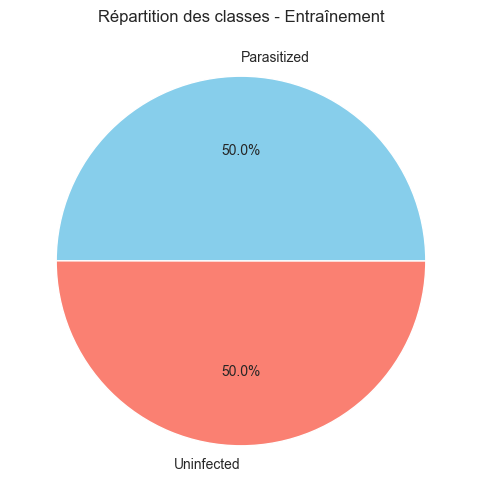

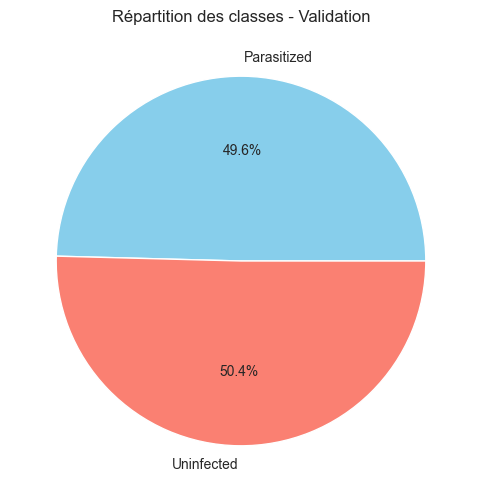

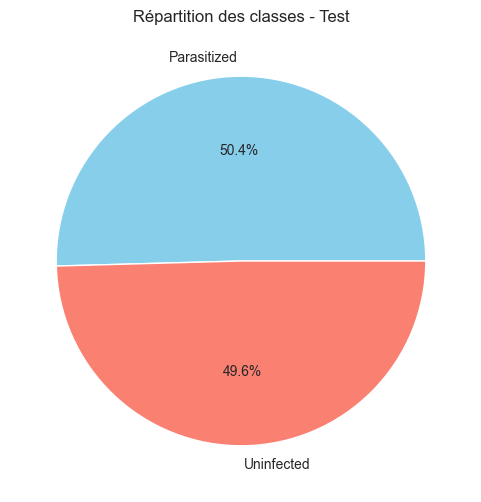

In [90]:
# 5. Répartition des classes
def plot_class_distribution(dataset, dataset_name, class_names=['Parasitized', 'Uninfected']):
    labels = np.concatenate([y.numpy() for _, y in dataset])
    unique, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(6, 6))
    plt.pie(
        counts,
        labels=[class_names[int(i)] for i in unique],
        autopct='%1.1f%%',
        colors=['skyblue', 'salmon']
    )
    plt.title(f"Répartition des classes - {dataset_name}")
    plt.show()

print("\nRépartition des classes dans chaque sous-dataset :")
plot_class_distribution(train_data, "Entraînement")
plot_class_distribution(val_data, "Validation")
plot_class_distribution(test_data, "Test")


In [93]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# 1. Conception du modèle CNN
def create_model(input_shape=(128, 128, 3)):
    model = models.Sequential([
        # Bloc Convolutionnel 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Bloc Convolutionnel 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Bloc Convolutionnel 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Couches entièrement connectées
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Régularisation Dropout
        layers.Dense(1, activation='sigmoid')  # Sortie binaire
    ])
    return model

# Initialiser le modèle
model = create_model()

# Afficher un résumé du modèle
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
# 2. Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [96]:
# 3. Configuration des Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',  # Surveiller la perte sur les données de validation
        patience=5,  # Arrêter l'entraînement après 5 époques sans amélioration
        verbose=1,
        restore_best_weights=True  # Restaurer les poids du meilleur modèle
    ),
    ReduceLROnPlateau(
        monitor='val_loss',  # Réduire le learning rate si la perte de validation stagne
        factor=0.2,  # Réduire de 80%
        patience=3,  # Après 3 époques sans amélioration
        verbose=1
    )
]

In [97]:
# 4. Entraînement du modèle
epochs = 10
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 163s 233ms/step - accuracy: 0.7490 - loss: 0.4920 - val_accuracy: 0.9481 - val_loss: 0.1587 - learning_rate: 0.0010
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 173s 252ms/step - accuracy: 0.9511 - loss: 0.1545 - val_accuracy: 0.9608 - val_loss: 0.1374 - learning_rate: 0.0010
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 172s 250ms/step - accuracy: 0.9585 - loss: 0.1319 - val_accuracy: 0.9623 - val_loss: 0.1334 - learning_rate: 0.0010
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 172s 249ms/step - accuracy: 0.9625 - loss: 0.1156 - val_accuracy: 0.9641 - val_loss: 0.1309 - learning_rate: 0.0010
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 169s 245ms/step - accuracy: 0.9644 - loss: 0.1044 - val_accuracy: 0.9604 - val_loss: 0.1389 - learning_rate: 0.0010
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 179s 259ms/step - accuracy: 0.9681 - loss: 0.0954 - val_accuracy: 0.9554 - val_loss: 0.1345 - learning_rate: 0.0010
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy

In [98]:
# 5. Évaluation des performances
print("\nÉvaluation sur les données de test :")
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Évaluation sur les données de test :
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9500 - loss: 0.1597
Test Loss: 0.1523
Test Accuracy: 0.9499


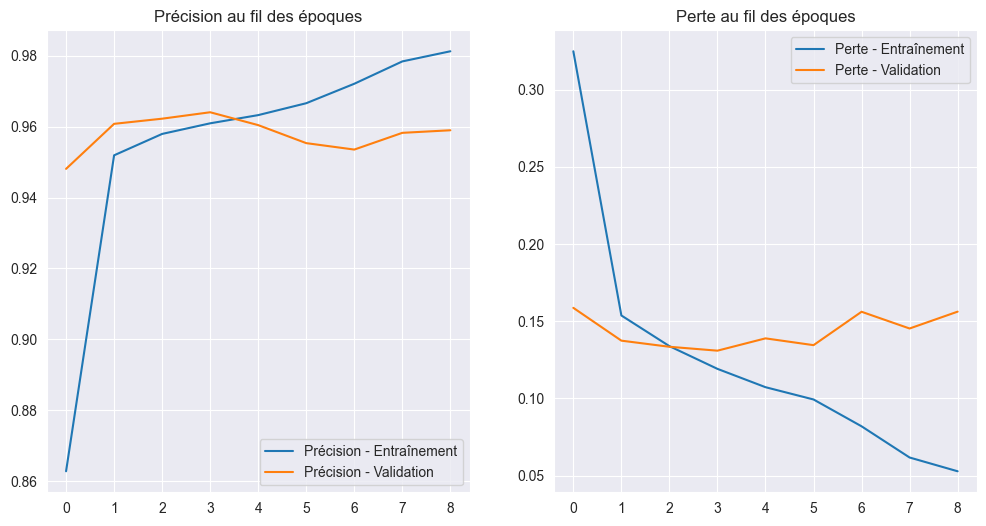

In [100]:
# 6. Affichage des courbes d'entraînement
def plot_training_history(history):
    """
    Affiche les courbes de précision et de perte au fil des époques.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Courbe de précision
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Précision - Entraînement')
    plt.plot(epochs_range, val_acc, label='Précision - Validation')
    plt.legend(loc='lower right')
    plt.title('Précision au fil des époques')

    # Courbe de perte
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perte - Entraînement')
    plt.plot(epochs_range, val_loss, label='Perte - Validation')
    plt.legend(loc='upper right')
    plt.title('Perte au fil des époques')

    plt.show()

# Affichage des courbes
plot_training_history(history)


In [101]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1. Définition du modèle avec Keras Tuner
def build_model(hp):
    model = models.Sequential()

    # Première couche convolutionnelle
    model.add(layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(128, 128, 3)
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Couches convolutionnelles supplémentaires
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(layers.Conv2D(
            filters=hp.Int(f'filters_{i+2}', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D((2, 2)))

    # Couches entièrement connectées
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))

    # Dropout pour éviter le surapprentissage
    model.add(layers.Dropout(0.5))

    # Sortie binaire
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compilation du modèle
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [102]:
# 2. Recherche des meilleurs hyperparamètres avec Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='malaria_model_tuning'
)

In [ ]:
# 3. Callbacks pour l'optimisation
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

In [ ]:
# 4. Lancer la recherche
tuner.search(train_data, validation_data=val_data, epochs=10, callbacks=callbacks)

# 5. Résultats des meilleurs hyperparamètres
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Meilleurs hyperparamètres : {best_hps.values}")

# 6. Créer et entraîner le modèle avec les meilleurs hyperparamètres
best_model = tuner.hypermodel.build(best_hps)
history_best_model = best_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks
)

# 7. Évaluation du modèle sur les données de test
test_loss, test_accuracy = best_model.evaluate(test_data, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
